<h2>Домашнее задание</h2>

<p>Воспользуемся реализованной моделью логистической регрессии, чтобы решить задачу определения пола пользователя Авито.</p>

<p><a href="https://stepik.org/media/attachments/lesson/527992/binary_clf_data.csv" rel="noopener noreferrer nofollow">Данные</a> даны в сыром виде &ndash; айтемы и их категории, которые выкладывали покупатели на Авито. Целевая переменная: <em>gender.</em></p>

<p>Вам необходимо разбить данные на train, val. Перед загрузкой файла с ответом убедитесь, что точность (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html" rel="noopener noreferrer nofollow">accuracy</a>)&nbsp;на валидации не менее 0.7.</p>

<p>&nbsp;</p>

<p><strong>План действий</strong></p>

<p>Сначала нужно преобразовать категории с помощью one-hot encoding. Далее необходимо агрегировать категории, в которых пользователи выкладывали объявления, чтобы получить вектор признаков для каждого объекта. В результате у каждого пользователя будет вектор признаков, содержащий количество айтемов, выложенных в каждой из возможных категорий.</p>

<ul>
	<li>Убедитесь, что для каждого пользователя в выборке есть только один объект, каждый признак означает количество айтемов, выложенное этим пользователем в категории;</li>
	<li>Убедитесь, что после one-hot энкодинга каждая категория соответствует признаку,&nbsp;<strong>одинаковому в train, val и test.</strong></li>
</ul>

<p>Попробуйте варианты отбора признаков. Для борьбы с переобучением на редких категориях используйте регуляризацию. В качестве&nbsp;ответа загрузите файл с предсказанием пола для пользователей:</p>

<p style="text-align:center">&nbsp;</p>

<table align="center" border="1" cellpadding="1" cellspacing="1" style="width:500px">
	<thead>
		<tr>
			<th style="text-align:center">user_id</th>
			<th style="text-align:center">gender</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td style="text-align:center">15424171</td>
			<td style="text-align:center">male</td>
		</tr>
		<tr>
			<td style="text-align:center">15454025</td>
			<td style="text-align:center">female</td>
		</tr>
	</tbody>
</table>

<p style="text-align:center">&nbsp;</p>

<p>Такой файл можно сформировать с помощью&nbsp;<code>test_predictions.to_csv(&#39;test_predictions.csv&#39;, index=False)</code>.</p>

<p>После того, как получилось обучить модель, ответьте на вопрос: какие из категорий вносят наибольший вклад в вероятность класса &quot;мужчина&quot; и класса &quot;женщина&quot;?</p>

<p>Например, если вы закодировали &quot;мужчина&quot; как 1, большие положительные веса при признаках будут означать большой вклад в вероятность класса 1, большие по модулю отрицательные веса будут вносить наибольший вклад в вероятность класса 0. Согласуется ли полученный результат с вашим жизненным опытом?</p>


In [11]:
import pandas as pd
import numpy as np
import numbers

In [196]:
from sklearn.metrics import accuracy_score, log_loss


class LogisticRegression:
    
    def __init__(self, max_iter=1e4, lr=0.001, tol=0.001, print_every=100, l1_coef: np.array = None):
        
        '''
        max_iter – максимальное количеств
        '''
        
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.print_every = print_every
        self.l1_coef = l1_coef
        
        self.weights = None
        self.bias = None
        
    def fit(self, X_train, y_train, X_val, y_val):
        
        '''
        Обучение модели.
        
        X_train – матрица объектов для обучения
        y_train – ответы на объектах для обучения
        
        X_val – матрица объектов для валидации
        y_val – ответы на объектах для валидации
        '''
        
        self.check_binary_clf_X_y(X_train, y_train)
        self.check_binary_clf_X_y(X_val, y_val)
        
        n, m = X_train.shape
        
        if self.l1_coef is None:
            self.l1_coef = 0.001 * np.ones(m).reshape(-1, 1)
        
        self.weights = np.zeros((m, 1))
        self.bias = 0
        
        n_iter = 0
        gradient_norm = np.inf
        
        while n_iter < self.max_iter and gradient_norm > self.tol:
            
            dJdw, dJdb = self.grads(X_train, y_train)
            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))
                
            self.weights = self.weights - self.lr * dJdw
            self.bias = self.bias - self.lr * dJdb
            
            n_iter += 1
            
            if n_iter % self.print_every == 0:
                self.print_metrics(X_train, y_train, X_val, y_val, n_iter, gradient_norm)
        
        return self
    
    def predict(self, X):  
        
        '''
        Метод возвращает предсказанную метку класса на объектах X
        '''
        
        return np.where(self.predict_proba(X) > 0.5, 1, 0)
        
    
    def predict_proba(self, X):
        
        '''
        Метод возвращает вероятность класса 1 на объектах X
        '''
    
        return self.sigmoid(X @ self.weights + self.bias)
    
    def grads(self, x, y):
        
        '''
        Рассчёт градиентов
        '''
        
        y_hat = self.predict_proba(x)
        
        dJdw = ((y_hat - y) * x).mean(axis=0, keepdims=True).T + (self.l1_coef * np.sign(self.weights)).reshape(-1, 1)
        dJdb = (y_hat - y).mean()
        
        self.check_grads(dJdw, dJdb)
        
        return dJdw, dJdb
    
    @staticmethod
    def sigmoid(x):
        
        '''
        Сигмоида от x
        '''
        
        return 1 / (1 + np.exp(-x))
    
    def print_metrics(self, X_train, y_train, X_val, y_val, n_iter, gradient_norm):
        
        train_preds = self.predict(X_train)
        train_predict_proba = self.predict_proba(X_train)
        val_preds = self.predict(X_val)
        
        train_acc = accuracy_score(train_preds, y_train)
        val_acc = accuracy_score(val_preds, y_val)
        
        loss = log_loss(y_train, train_predict_proba)
        
        print(f'{n_iter} completed. accuracy_score on train: {train_acc}, val: {val_acc}, loss: {loss}')
        
    def check_grads(self, dJdw, dJdb):
        
        if not isinstance(dJdb, numbers.Real):
            raise ValueError(f'Производная по параметру b должна быть действительным'
                             f' числом, как и сам параметр b, а у нас {dJdb} типа {type(dJdb)}')
            
        if dJdw.shape != self.weights.shape:
            raise ValueError(f'Размерность градиента по параметрам w должна совпадать с самим вектором w, '
                             f'а у нас dJdw.shape = {dJdw.shape} не совпадает с weight.shape = {self.weights.shape}')
    
    @staticmethod
    def check_binary_clf_X_y(X, y):
        
        if X.shape[0] == 0:
            raise ValueError(f'X и y не должны быть пустыми, а у нас X.shape = {X.shape} и y.shape = {y.shape}')
            
        if np.isnan(X).any():
            raise ValueError(f'X не должен содержать "not a number" (np.nan)')
            
        if np.isnan(y).any():
            raise ValueError(f'y не должен содержать "not a number" (np.nan)')
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'Длина X и y должна быть одинаковой, а у нас X.shape = {X.shape}, y.shape = {y.shape}')
            
        if y.shape[1] != 1:
            raise ValueError(f'y - вектор ответов должен быть размерности (m, 1), а у нас y.shape = {y.shape}')

                    
        if sorted(np.unique([1, 0, 0])) != [0, 1]:
            raise ValueError(f'Ответы на объектах должны быть только 0 или 1, а у нас np.unique(y) = {np.unique(y)}')


# Данные

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

SEED = 100

In [184]:
data = pd.read_csv('binary_clf_data.csv')

In [185]:
y = np.where(data['gender'] == 'female', 1, 0)

In [186]:
X_train, X_val, y_train, y_val = train_test_split(data[['user_id','category_id']], y, test_size=0.3,random_state=SEED)

In [187]:
# cat transformer
category_ohe = OneHotEncoder(sparse=False)
train_category_ohe = category_ohe.fit_transform(X_train['category_id'].values.reshape(-1, 1))
val_category_ohe = category_ohe.transform(X_val['category_id'].values.reshape(-1, 1))

In [188]:
train_ohe = pd.DataFrame(train_category_ohe, index=X_train['user_id']).groupby('user_id').sum()
val_ohe = pd.DataFrame(val_category_ohe, index=X_val['user_id']).groupby('user_id').sum()

y_train_grouped = pd.DataFrame(y_train, index=X_train['user_id'], columns=['gender_binary']).groupby('user_id').min()
y_val_grouped = pd.DataFrame(y_val, index=X_val['user_id'], columns=['gender_binary']).groupby('user_id').min()

In [189]:
X_y_train = train_ohe.join(y_train_grouped)
X_y_val = val_ohe.join(y_val_grouped)

In [190]:
X_train_modified = X_y_train.drop(columns=['gender_binary']).values
X_val_modified = X_y_val.drop(columns=['gender_binary', 0, 5, 7]).values

y_train = X_y_train['gender_binary'].values.reshape(-1,1)
y_val = X_y_val['gender_binary'].values.reshape(-1,1)

In [205]:
mod_4_6_train = (X_train_modified[:, 4] * X_train_modified[:, 6]).reshape(-1, 1)
mod_4_6_val = (X_val_modified[:, 4] * X_val_modified[:, 6]).reshape(-1, 1)

mod_2_3_train = (X_train_modified[:, 2] * X_train_modified[:, 3]).reshape(-1, 1)
mod_2_3_val = (X_val_modified[:, 2] * X_val_modified[:, 3]).reshape(-1, 1)

X_train_modified = np.hstack([X_train_modified, mod_4_6_train, mod_2_3_train])
X_val_modified = np.hstack([X_val_modified, mod_4_6_val, mod_2_3_val])

In [224]:
reg = LogisticRegression(
    max_iter=300000, 
    lr=0.00001, 
    tol=0.001, 
    print_every=10000, 
    l1_coef=np.array([0.01, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001]).reshape(-1, 1)
)
reg.fit(X_train_modified, y_train, X_val_modified, y_val)

10000 completed. accuracy_score on train: 0.6618020304568528, val: 0.6411764705882353, loss: 0.6858409456393267
20000 completed. accuracy_score on train: 0.6592639593908629, val: 0.6441176470588236, loss: 0.6814595327177903
30000 completed. accuracy_score on train: 0.6383248730964467, val: 0.6147058823529412, loss: 0.6782497180809122
40000 completed. accuracy_score on train: 0.6383248730964467, val: 0.6137254901960785, loss: 0.6757335509929306
50000 completed. accuracy_score on train: 0.6357868020304569, val: 0.6127450980392157, loss: 0.6736840010212481
60000 completed. accuracy_score on train: 0.6364213197969543, val: 0.6137254901960785, loss: 0.6719691997531312
70000 completed. accuracy_score on train: 0.6364213197969543, val: 0.6137254901960785, loss: 0.6705048389228145
80000 completed. accuracy_score on train: 0.6364213197969543, val: 0.6127450980392157, loss: 0.669235984349343
90000 completed. accuracy_score on train: 0.6370558375634517, val: 0.6127450980392157, loss: 0.6681224735

In [225]:
{i: w for i, w in zip(range(reg.weights.shape[0]),reg.weights)}

{0: array([4.57179763e-08]),
 1: array([-0.05124934]),
 2: array([-0.13676113]),
 3: array([-0.12873013]),
 4: array([0.0512128]),
 5: array([2.09668455e-08]),
 6: array([0.047363]),
 7: array([-1.41009806e-07]),
 8: array([-0.02320605]),
 9: array([-0.03107797]),
 10: array([0.05798193]),
 11: array([-0.01118248])}

In [132]:
import matplotlib.pyplot as plt

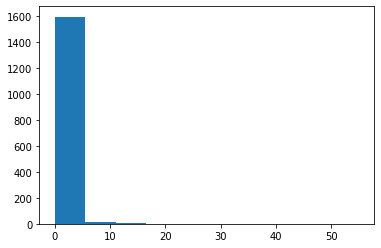

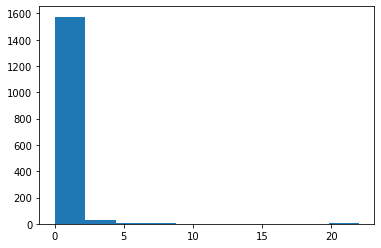

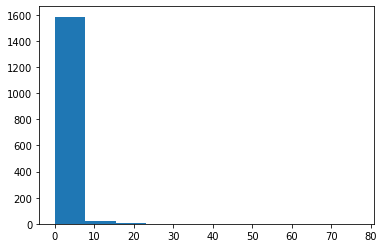

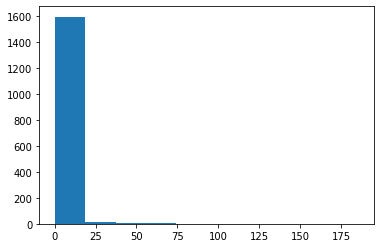

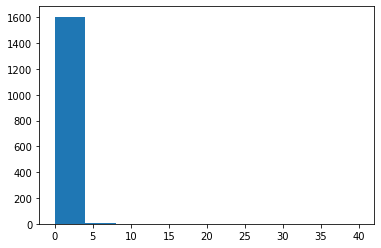

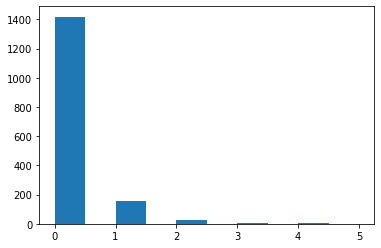

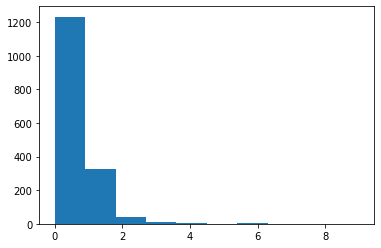

In [135]:
for x in X_train_modified.T:
    fig, ax = plt.subplots()
    ax.hist(x)

In [141]:
X_train_modified.sum(axis=0)

array([ 641.,  408., 1232., 2160.,  227.,  259.,  486.])

# test

In [218]:
test = pd.read_csv('dataset_527992_9.csv')

In [219]:
test

,user_id,category_id,category_name,subcategory_id,subcategory_name,param1,param2,param3,param1_microcat_id,param2_microcat_id,param3_microcat_id
0,154189609,7,Хобби и отдых,4,Велосипеды,Детские,NaN,NaN,1246.0,NaN,NaN
1,154189609,17,Бытовая электроника,29,Товары для компьютера,Комплектующие,Видеокарты,NaN,1651.0,6491.0,NaN
2,154189609,17,Бытовая электроника,41,Телефоны,iPhone,NaN,NaN,7315.0,NaN,NaN
3,154189609,17,Бытовая электроника,41,Телефоны,Xiaomi,NaN,NaN,10750009.0,NaN,NaN
4,154189728,28,Личные вещи,22,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,46–48 (L),1989.0,6949.0,775.0
...,...,...,...,...,...,...,...,...,...,...,...
3185,154263224,250003,Работа,250004,Резюме,"Без опыта, студенты",NaN,NaN,2179.0,NaN,NaN
3186,154265872,28,Личные вещи,47,Товары для детей и игрушки,Игрушки,NaN,NaN,5428.0,NaN,NaN
3187,154265872,28,Личные вещи,47,Товары для детей и игрушки,Игрушки,NaN,NaN,5428.0,NaN,NaN
3188,154265872,28,Личные вещи,47,Товары для детей и игрушки,Игрушки,NaN,NaN,5428.0,NaN,NaN
